In [1]:
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
import pandas as pd
import numpy as np

# allows importing notebooks as modules
from notebook_import import *

D:\Programs\Anaconda\envs\py35\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from log_parsing_notebook import load_behavioral_data, compile_trials
from utility_functions import prop_true

TDMS_PATH = 'D:/Work/tdms_logs'
TXT_PATH = 'D:/Dropbox/Work/envelope_discrimination/txt_logs'
CSV_PATH = 'D:/Dropbox/Work/envelope_discrimination/csv_logs'
RATS = ['S8','S9','S10']

importing Jupyter notebook from D:\Dropbox\Work\iPython\log_parsing_notebook.ipynb
importing Jupyter notebook from D:\Dropbox\Work\iPython\utility_functions.ipynb


In [3]:
# load behavioral data into memory
ld = load_behavioral_data(TXT_PATH,TDMS_PATH,CSV_PATH,RATS)

In [4]:
drop_sessions = ['20160712S8', # task parameter (delay) changed and the rat was confused
                 '20160713S8',
                 '20160714S8',
                 '20160715S8',
                 '20160716S8',
                 '20160717S8']



sessions_with_mixed_trials = pd.Series([s for s in ld.index if 'Mixed_trial_info' in ld[s].keys() 
                              # only select sessions with '5-1' sequences present (these will also contain '1-5') 
                              and '5-1' in ld[s].Mixed_trial_info.unique()
                              # drop some sessions for various reasons
                              and s not in drop_sessions])

# leave only relevant sessions with mixed trials
ld = ld[sessions_with_mixed_trials]
print('There are %s sessions with mixed trials.' % len(ld))

There are 114 sessions with mixed trials.


D:\Programs\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [5]:
# create a tidy dataset with all trials
trials = compile_trials(ld)

print('There are %s trials in total, %s of them are mixed trials' %
     (len(trials), len(trials.dropna(subset=['mixed_sequence']))) )

There are 27659 trials in total, 1594 of them are mixed trials


#### Visualize performance on normal trials for each rat and session
This allows to see trends in the long-term, and visually check if performance in some periods is strangely low. Chance performance is 50%.

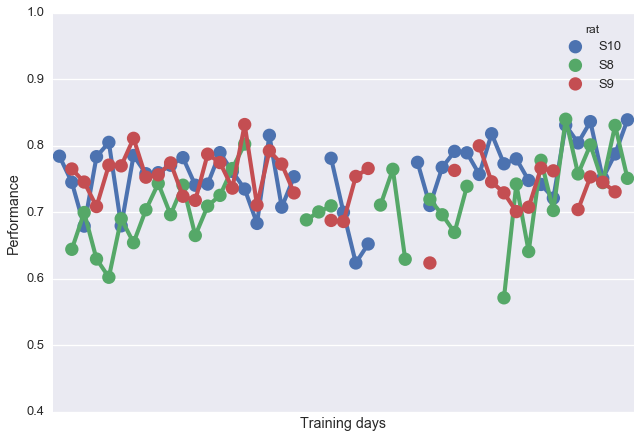

In [6]:
# get normal trials only
nt = trials[trials.mixed_sequence.isnull()]

# groupby rat and date and calculate proportion of correct trials,
# which gives performance on each session for each rat
perf = nt.groupby(['rat','date']).correct.apply(prop_true).reset_index()

# plot
sns.pointplot(data=perf,x='date',y='correct',hue='rat')
plt.xticks([])
plt.xlabel('Training days')
plt.ylim([0.4,1])
plt.ylabel('Performance')
plt.show()

#### Analyse mixed trials
Mixed trials are trials with one modulation frequency in the first second and another in the second second: 1 Hz in the first second and 5 Hz in the second second (1-5 mixed sequence), or vice versa (5-1 mixed sequence). The question is how rats decide to choose on these trials -- according to the first modulation frequency or the second one. This will tell us which part of the stimulus has more weight for the animal.

In [37]:
# get only mixed trials
mt = trials[trials.mixed_sequence.notnull()]

# calculate proportion of choice to right for 5-1 and 5-1 mixed sequences for each rat 
prop_right = mt.groupby(['rat','mixed_sequence'])['choice'].apply(lambda x: sum(x=='Right')/len(x)).reset_index()
prop_right.rename(columns={"choice": "prop_choices_right"},inplace=True)
prop_right

,rat,mixed_sequence,prop_choices_right
0,S10,1-5,0.718412
1,S10,5-1,0.259786
2,S8,1-5,0.709924
3,S8,5-1,0.426415
4,S9,1-5,0.738462
5,S9,5-1,0.373494


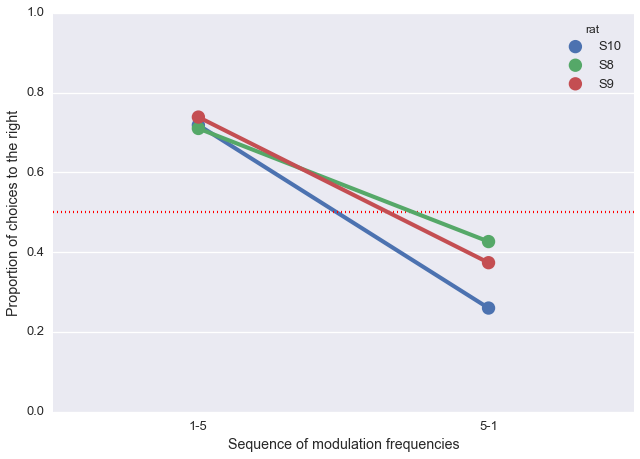

In [36]:
sns.pointplot(data=prop_right,x='mixed_sequence',y='prop_choices_right',hue='rat')

# chance level choice
plt.hlines(0.5,*plt.gca().get_xlim(),linestyles=':',colors='r')

plt.ylim([0,1])
plt.ylabel('Proportion of choices to the right')
plt.xlabel('Sequence of modulation frequencies')
plt.show()